In [1]:
# BASICS
import xarray as xr
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
from pyproj import Proj, itransform, transform
import cftime

# PLOTS
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from matplotlib.colors import from_levels_and_colors, ListedColormap
import cartopy.crs as ccrs

# REGRIDDING
import xesmf as xe

# CUSTOM FUNCTIONS
import utils

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

##### FUNCTIONS

In [2]:
max_breakup_doy,min_freezup_doy = 200,265 # 265,265 would be better ~September 25
timedim = 'time'
colors = {'DFS':'blue','CGRF':'green','JRA':'orange','ASMR':'red'}
runs = {'DFS':'G510.00','CGRF':'C524.06','JRA':'C524.00-08'}

def doy_to_date(x,year=2001):
    return datetime(year, 1, 1) + timedelta(int(x) - 1)

doy_to_month = lambda x: np.nan if np.isnan(x) else int((datetime(2001, 1, 1) + timedelta(x - 1)).strftime('%m'))
f_format_month = lambda x: datetime(2001,x,1).strftime('%b')

def date_to_cftime(x):
    by,bm,bd = x.strftime('%Y-%m-%d').split("-")
    return cftime.DatetimeNoLeap(int(by), int(bm), int(bd), 12, 0, 0, 0, has_year_zero=True)#, f"{bm}-{bd}"

def doy_to_cftime(x,year):
    by,bm,bd = doy_to_date(int(x),year).strftime('%Y-%m-%d').split("-")
    return cftime.DatetimeNoLeap(int(by), int(bm), int(bd), 12, 0, 0, 0, has_year_zero=True)#, f"{bm}-{bd}"

def proc_sic(sic,threshold=0.5,timedim='time'):
    """ first day after winter max SI concetration is below threshold
        return Nan for cells with max above or min below threshold for 30 day rolling mean
        Note: if your sic dataset is not daily, use .resample(time="1D").interpolate("linear") prior to this function.
        Note: it assumes 365-days years. ### Version used in Antoine's paper ###
    """
    global max_breakup_doy,min_freezup_doy
    
    t = threshold/100.0 if threshold>1 else threshold
    suffix = int(t*100)
    doys = sic[timedim].dt.dayofyear
    
    # set=0 if SI always below or above threshold - will return day 0 which is then changed to nan
    # use 30 day rolling mean for this
    smth30_sic = sic.rolling(dim={timedim:30},center=True,min_periods=1).mean()
    sic_dropbelow = xr.where((smth30_sic.max(dim=[timedim]) <t) | (smth30_sic.min(dim=[timedim]) >t), 0, sic)
    # for finding day of threshold, smooth daily signal with 14 day rolling mean
    smth_sic = sic_dropbelow.rolling(dim={timedim:14},center=True,min_periods=1).mean()
    # smth30_sic = sic_dropbelow.rolling(dim={timedim:30},center=True,min_periods=1).mean()
    
    # winter max ; before day 200 ; need to fill nan because argmax is stupid
    wmax = smth_sic.where(doys<max_breakup_doy).fillna(0).argmax(dim=timedim)+1
    # SIc afetr winter max
    sic_afterwintermax = smth_sic.where(doys>=wmax)
    # floor at threshold
    sic_floored = xr.where(sic_afterwintermax<t, t, sic_afterwintermax)
    # # first min is day threshold is reached
    iday = sic_floored.fillna(1).argmin(dim=timedim)+1
    # iday > 1 to filter NaNs
    res = iday.where(iday>1)

    # selecting freeze-up time range
    sic_afterminfreezup = smth_sic.where(doys>=min_freezup_doy)
    # setting minimum sic to threshold
    sic_floored = xr.where(sic_afterminfreezup>t, t, sic_afterminfreezup)
    # selecting time of the first minimum i.e. time of the first 0.5 sic
    iday1 = sic_floored.fillna(0).argmax(dim=timedim)+1
    res1 = iday1.where(iday1>0)
    
    d_res = {'wmax':wmax,'sibd':res,'sifd':res1,'smth_sic':smth_sic} #,'smth30_sic':smth30_sic}
    return d_res

def plot_daily_sic(years,data,figtitle=None,savepath=None):
    global colors

    fig, axs = plt.subplots(nrows=len(years),figsize=(15,3*len(years)))
    for i,year in enumerate(years):
        for k in data[year]:
            data[year][k].plot(ax=axs[i],lw=1,alpha=1,c=colors[k],label=f"{k}")
        axs[i].legend()
        axs[i].set_title(None)
        axs[i].set_xlabel(None)
        axs[i].grid()
    fig.tight_layout()
    fig.suptitle(figtitle)
    if savepath:
        plt.savefig(savepath)
    else:
        plt.show()
        
def plot_dates(year,data,d,figtitle=None,savepath=None):
    global colors
    
    fig, ax = plt.subplots(figsize=(15,2))
    data[year]['ASMR'].plot(ax=ax,lw=1,alpha=0.7,c='gray',label='ASMR')
    for k in data[year]: #['DFS','ASMR']:
        # data[year][k].plot(ax=ax,lw=1,alpha=1,c=colors[k],label=f"{k}")
        # d[year][k][50]['smth_sic'].plot(ax=ax,lw=3,ls='--',alpha=1,c=colors[k],label=f"Rolling 14d")
        d[year][k][50]['smth_sic'].plot(ax=ax,lw=1,alpha=1,c=colors[k],label=f"{k} rolling 14d")
        for t in [85,50]:
            ax.axvline(x=doy_to_cftime(d[year][k][t]['wmax'],year),ls='--',c=colors[k],ymin=0,ymax=1,label=None)
            ax.axvline(x=doy_to_cftime(d[year][k][t]['sibd'],year),ls='--',c=colors[k],ymin=0,ymax=t/100.0,label=None)
            ax.axvline(x=doy_to_cftime(d[year][k][t]['sifd'],year),ls='--',c=colors[k],ymin=0,ymax=t/100.0,label=None)
    ax.axhline(y=0.5,ls='--',c='k',alpha=0.4)
    ax.axhline(y=0.85,ls='--',c='gray',alpha=0.4)
    ax.legend()
    ax.grid()
    ax.set_title(figtitle)
    ax.set_xlabel(None)
    if savepath:
        plt.savefig(savepath)
    else:
        plt.show()



##### REGIONAL PLOTS

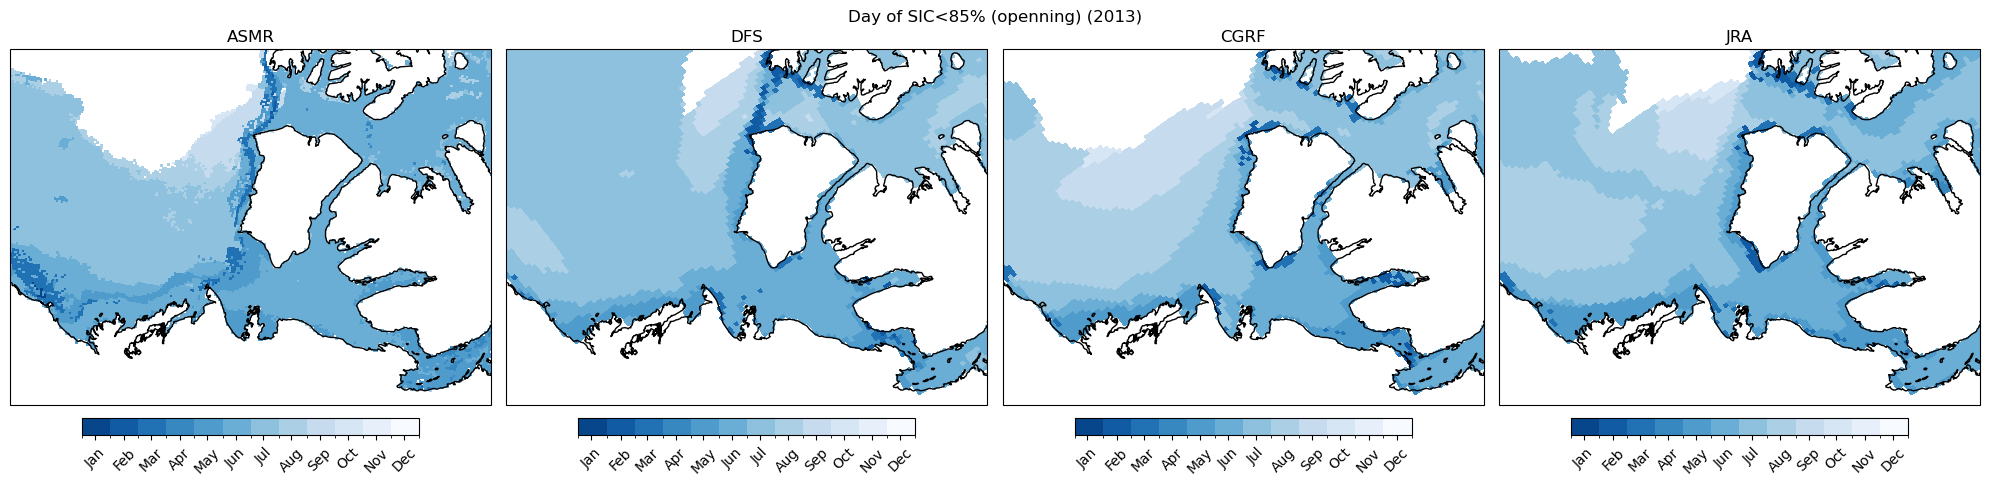

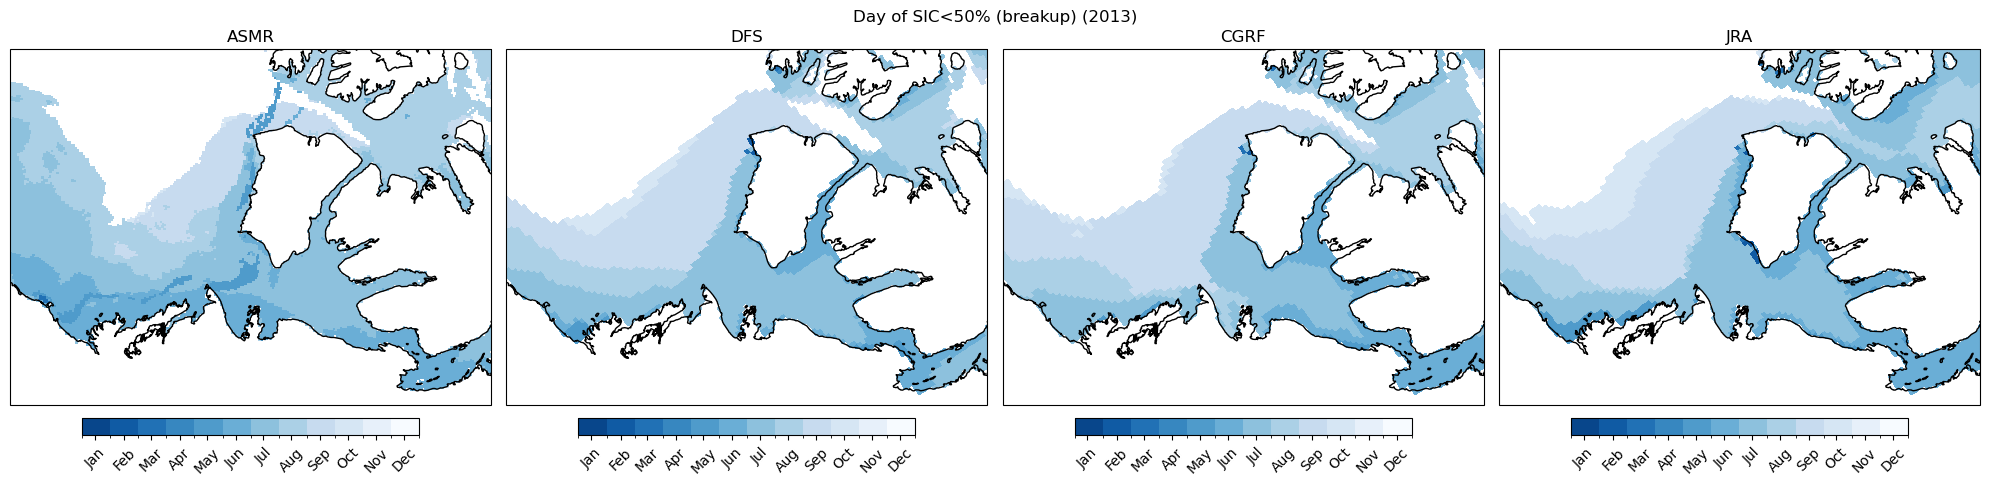

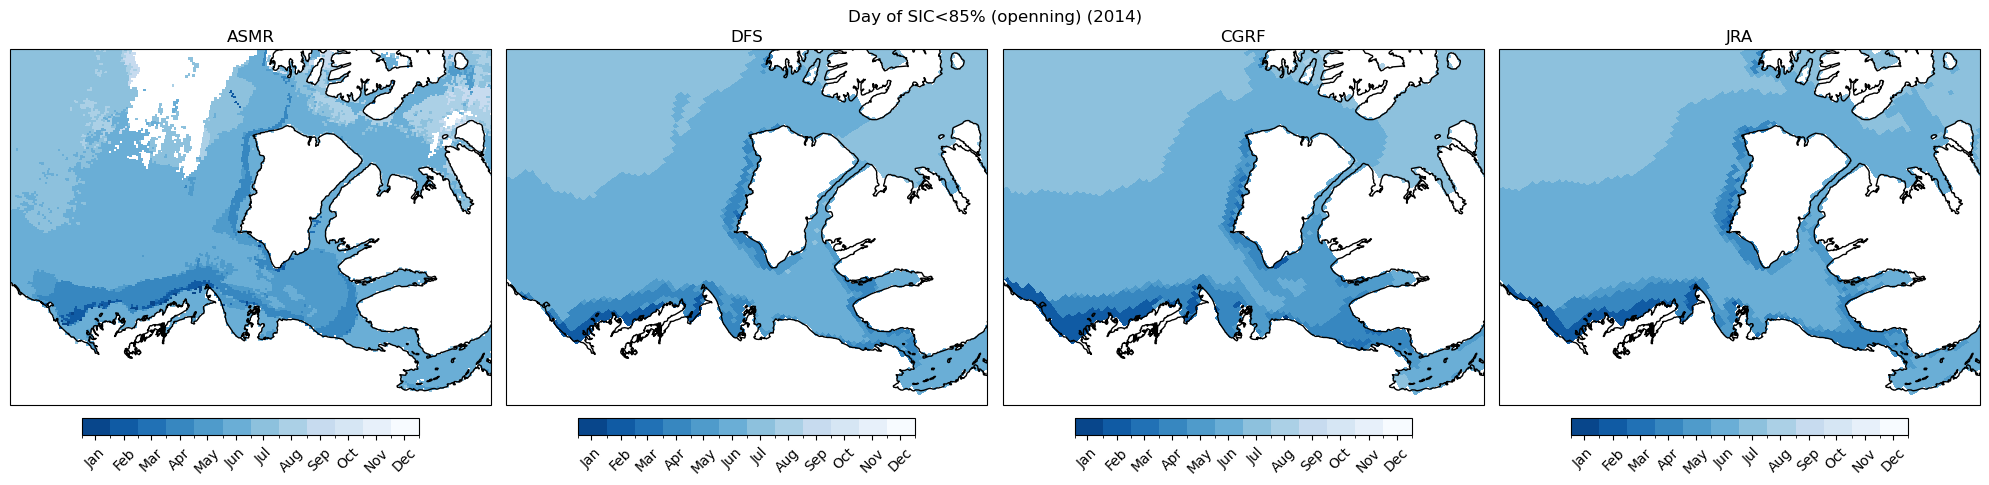

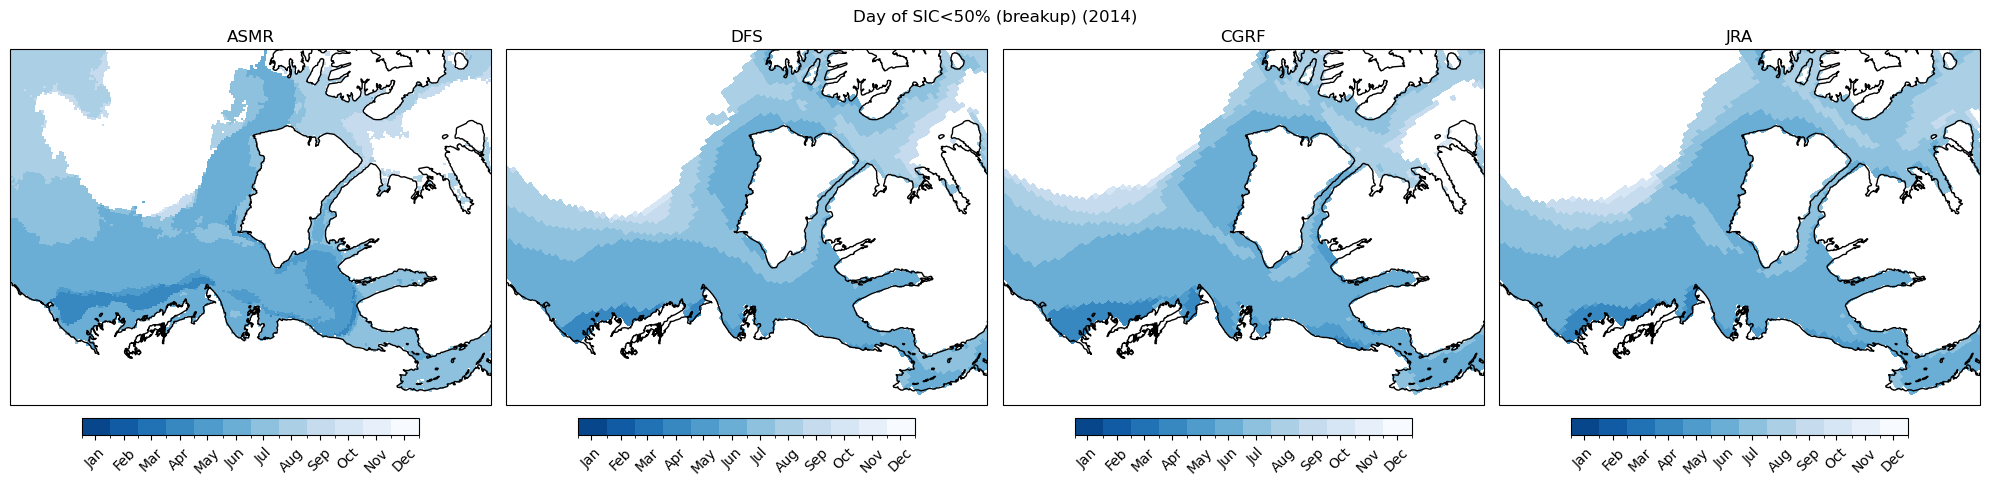

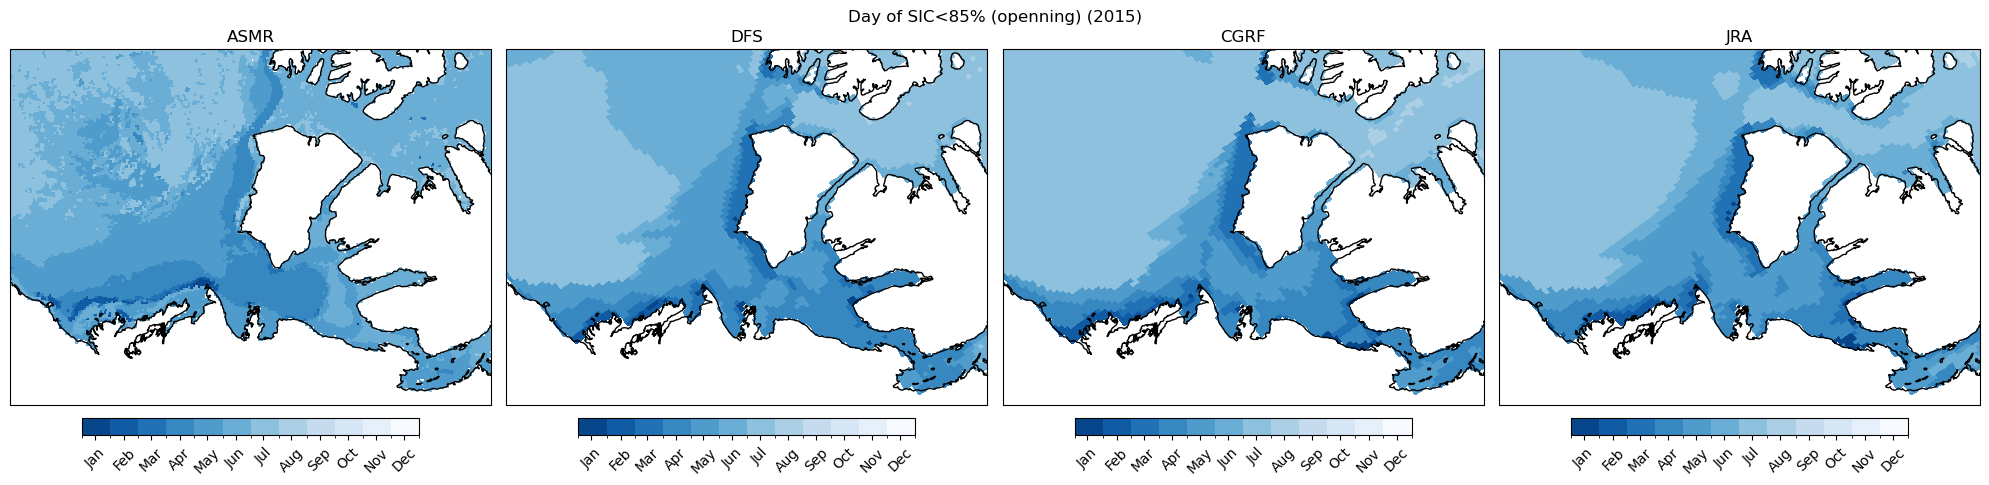

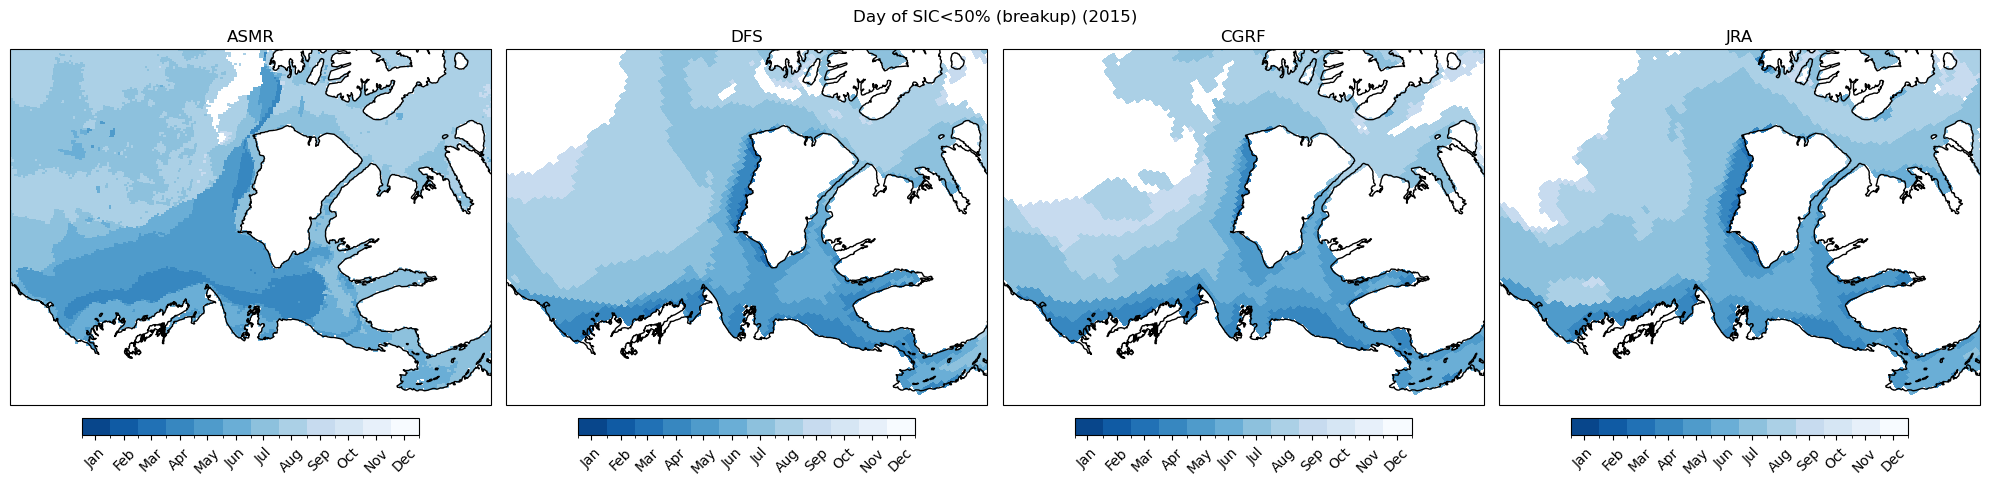

In [18]:
save_dir = '/home/pfarnole/data/sibd/'
plot_extent = [-140,-110,67,76] #[-180,180,60,90] # [-140,-110,67,75] #[-180,180,60,90] [-135,-100,67,75]
central_longitude = 0.5*(plot_extent[0]+plot_extent[1])
doys = {'sibd85':'Day of SIC<85% (openning)',
        'sibd50':'Day of SIC<50% (breakup)',
        # 'sifd50':'Day of SIC>50% (freezup)',
        # 'sifd85':'Day of SIC>85% (closing)',
       }
datasets = ['ASMR','DFS','CGRF','JRA']
ncols = len(datasets)
cmap = plt.get_cmap('Blues_r')

for y in range(2013,2016):
    for k in doys:
        fig, axs = plt.subplots(ncols=ncols,figsize=(5*ncols,5),subplot_kw={'projection':ccrs.NorthPolarStereo(central_longitude=central_longitude)})
        fig.suptitle(f"{doys[k]} ({y})")
        for i,ds in enumerate(datasets):
            data_path = os.path.join(save_dir+ds,f'{y}.nc')
            datay = xr.open_dataset(data_path).sel(year=y)
            cmap, norm, m_labels, m_ticks = generate_cmap(y)
            axs[i].coastlines()
            axs[i].set_title(ds)
            axs[i].set_extent(plot_extent, ccrs.PlateCarree())
            pl = axs[i].pcolormesh(datay.lon,datay.lat,datay[k].where(datay[k]),transform=ccrs.PlateCarree(),cmap=cmap,norm=norm)
            cbar = plt.colorbar(pl,ax=axs[i],orientation='horizontal',label=None,shrink=0.7,pad=0.03,ticks=m_ticks)
            cbar.ax.set_xticklabels(m_labels,rotation=45)
        fig.tight_layout()
        plt.show()

#### LOCATIONS

ulu2 (lat=70.38, lon=-117.95)
2016
2017
2018
2019
ag_middle (lat=70.5, lon=-120.3)
2016
2017
2018
2019
ag_north (lat=71.2, lon=-119.7)
2016
2017
2018
2019
dolphin_union (lat=69.35, lon=-117.5)
2016
2017
2018
2019
ag_south (lat=69.9, lon=-119.2)
2016
2017
2018
2019
ag_entrance2 (lat=70.6, lon=-123)
2016
2017
2018
2019


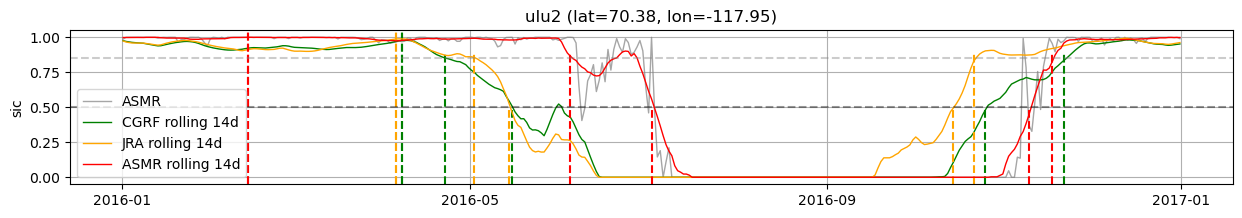

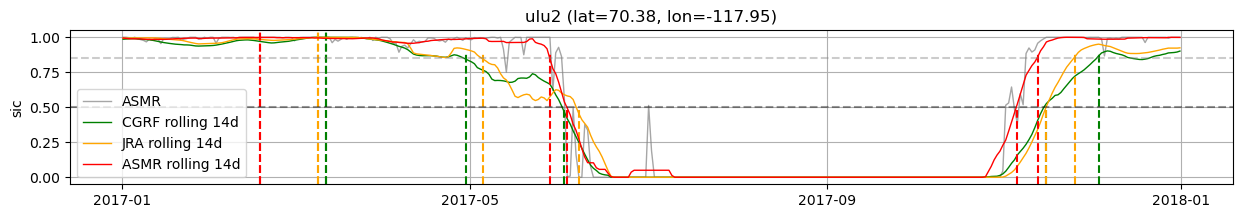

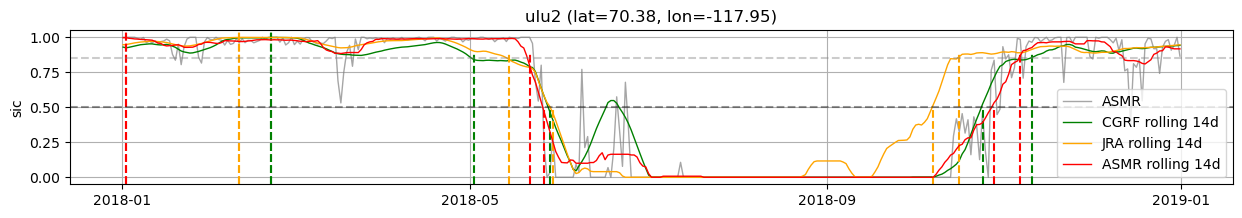

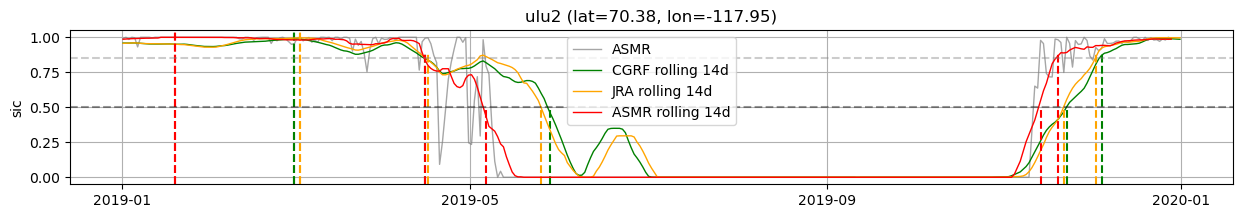

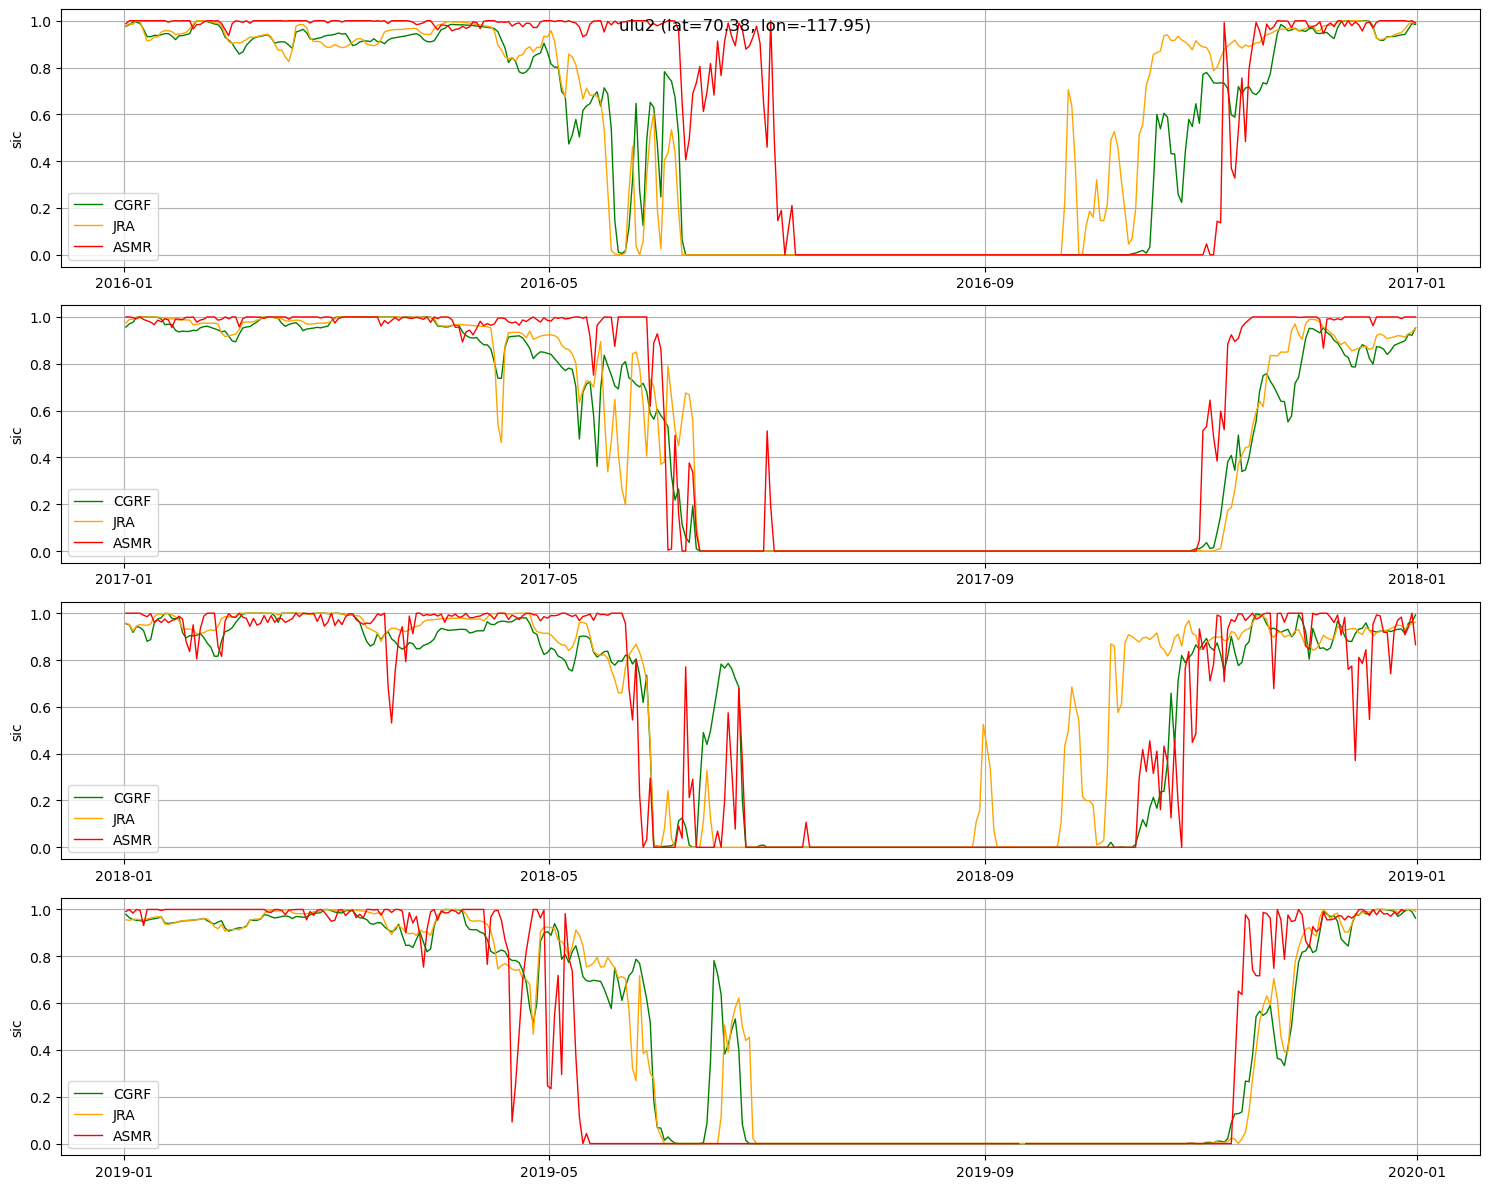

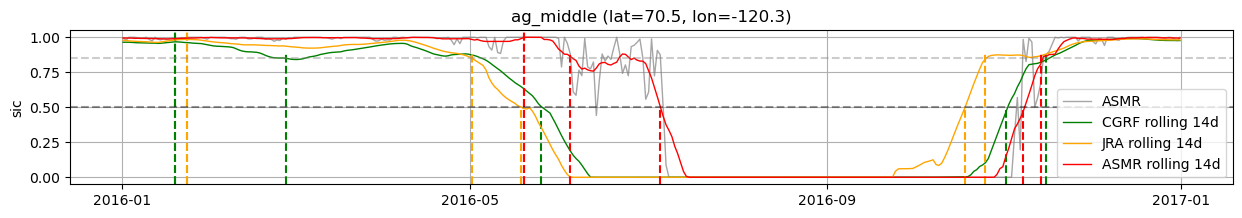

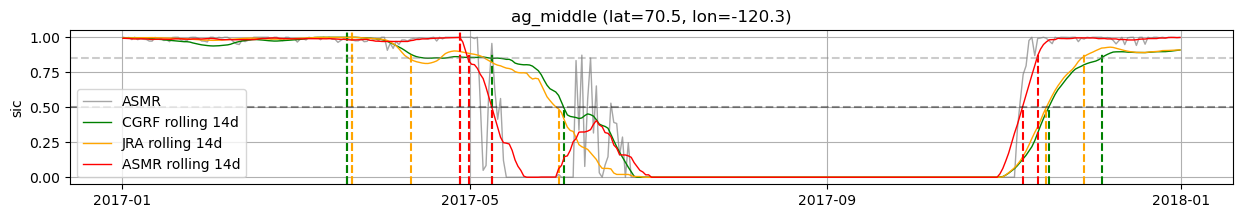

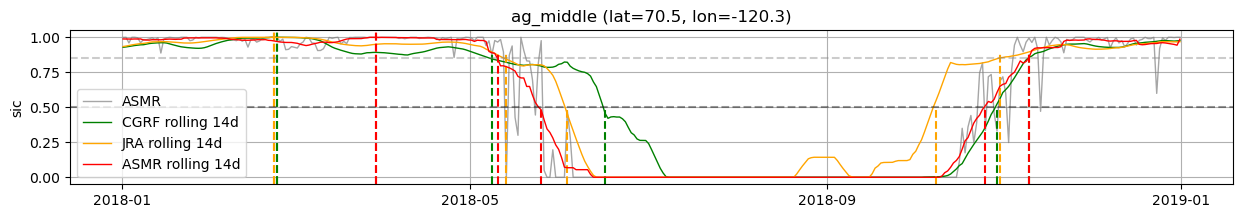

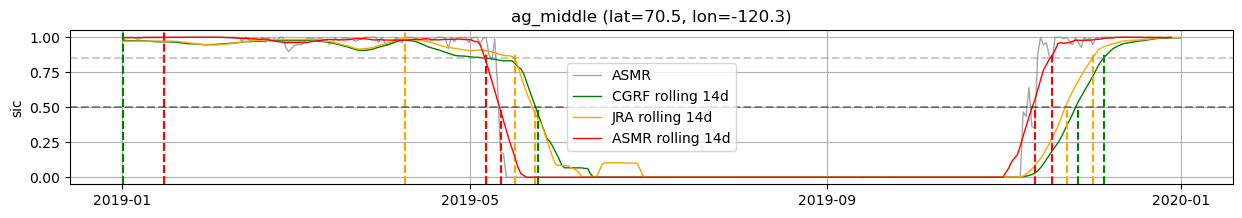

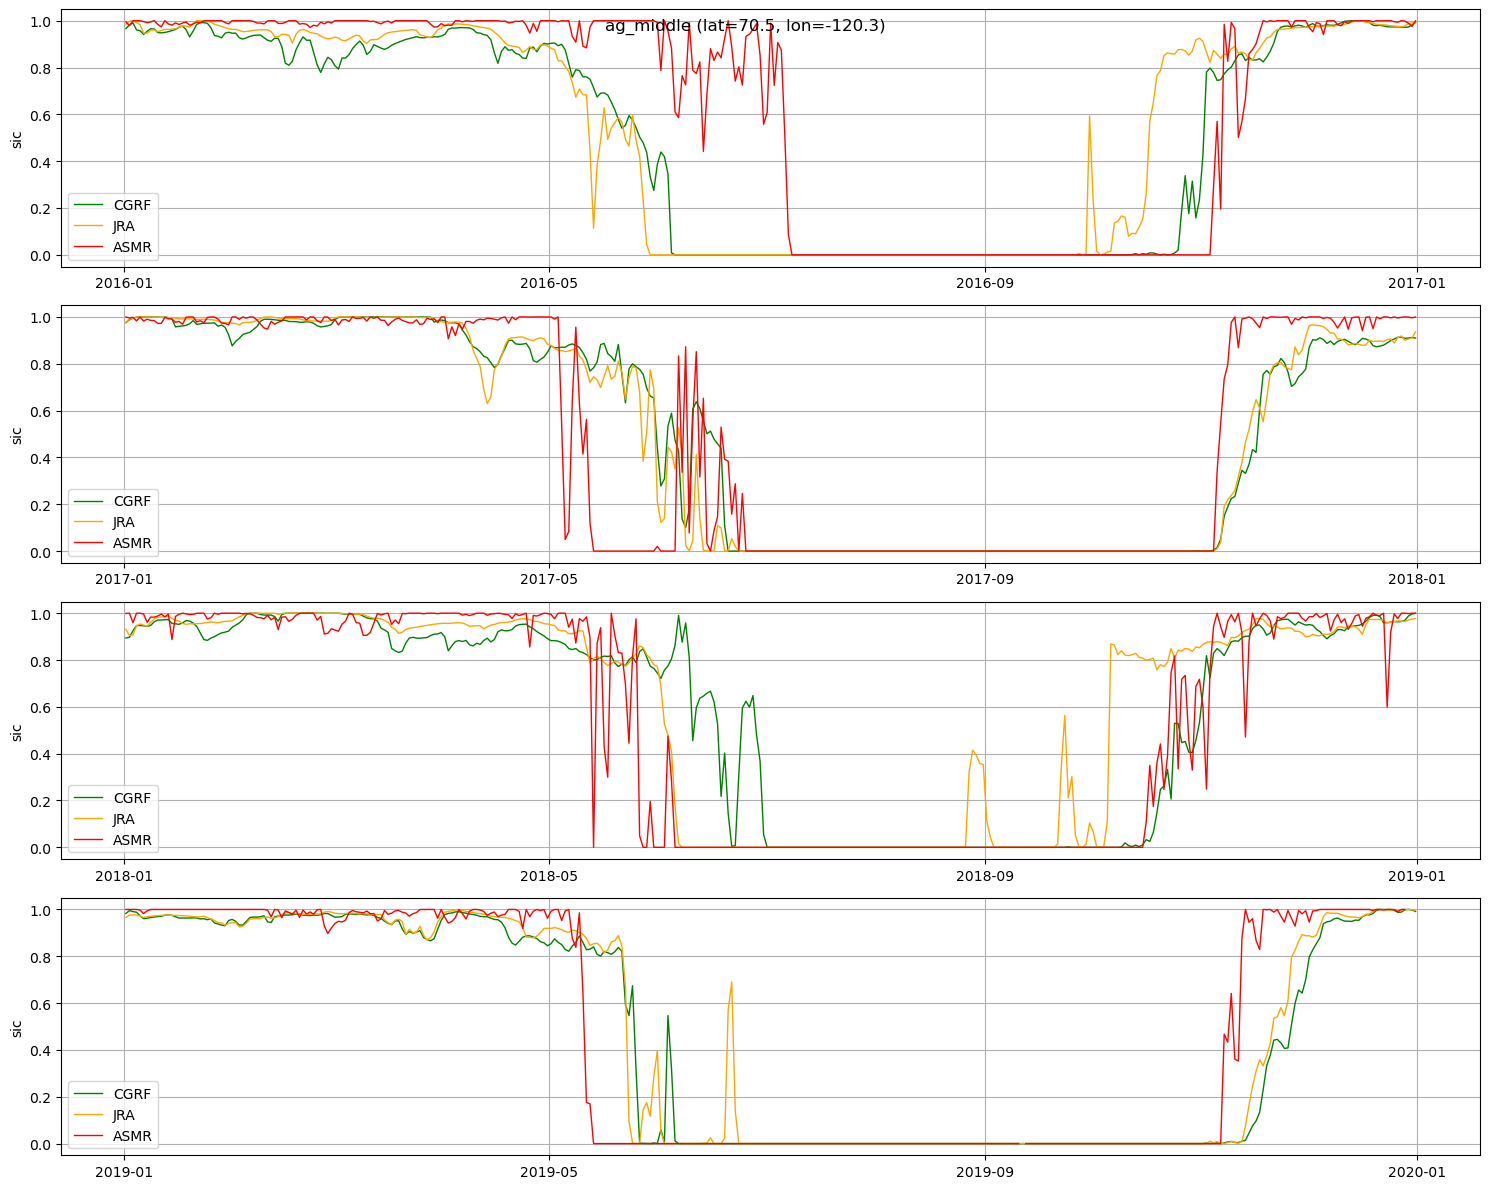

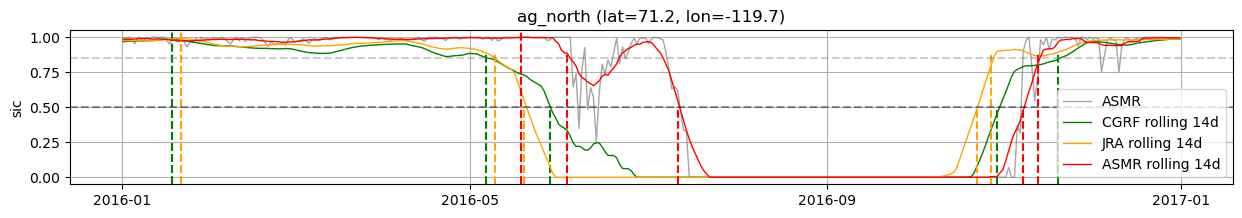

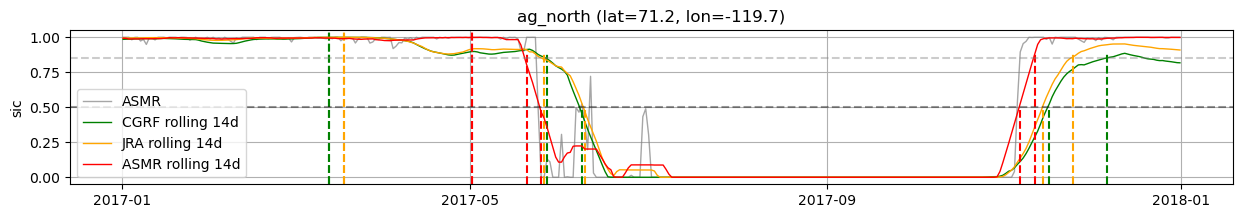

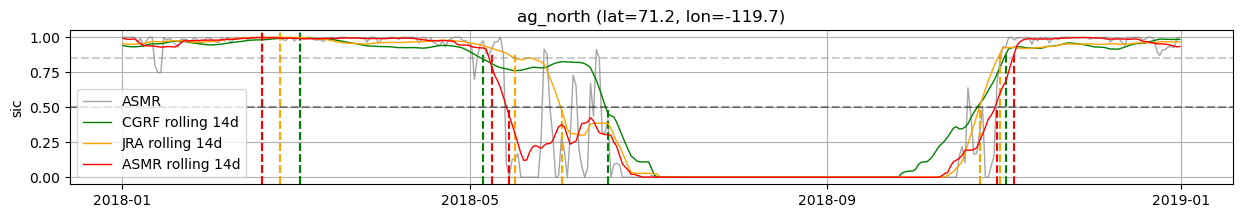

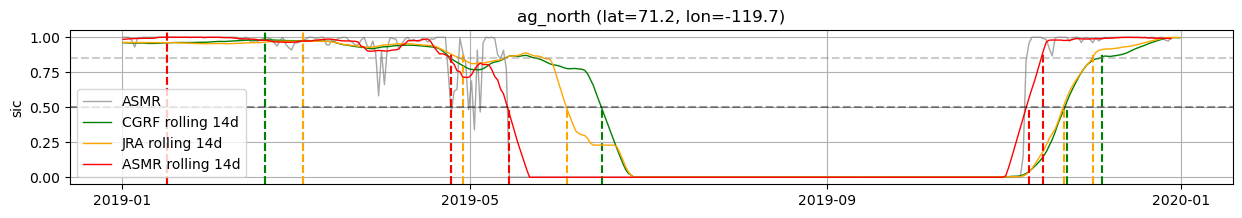

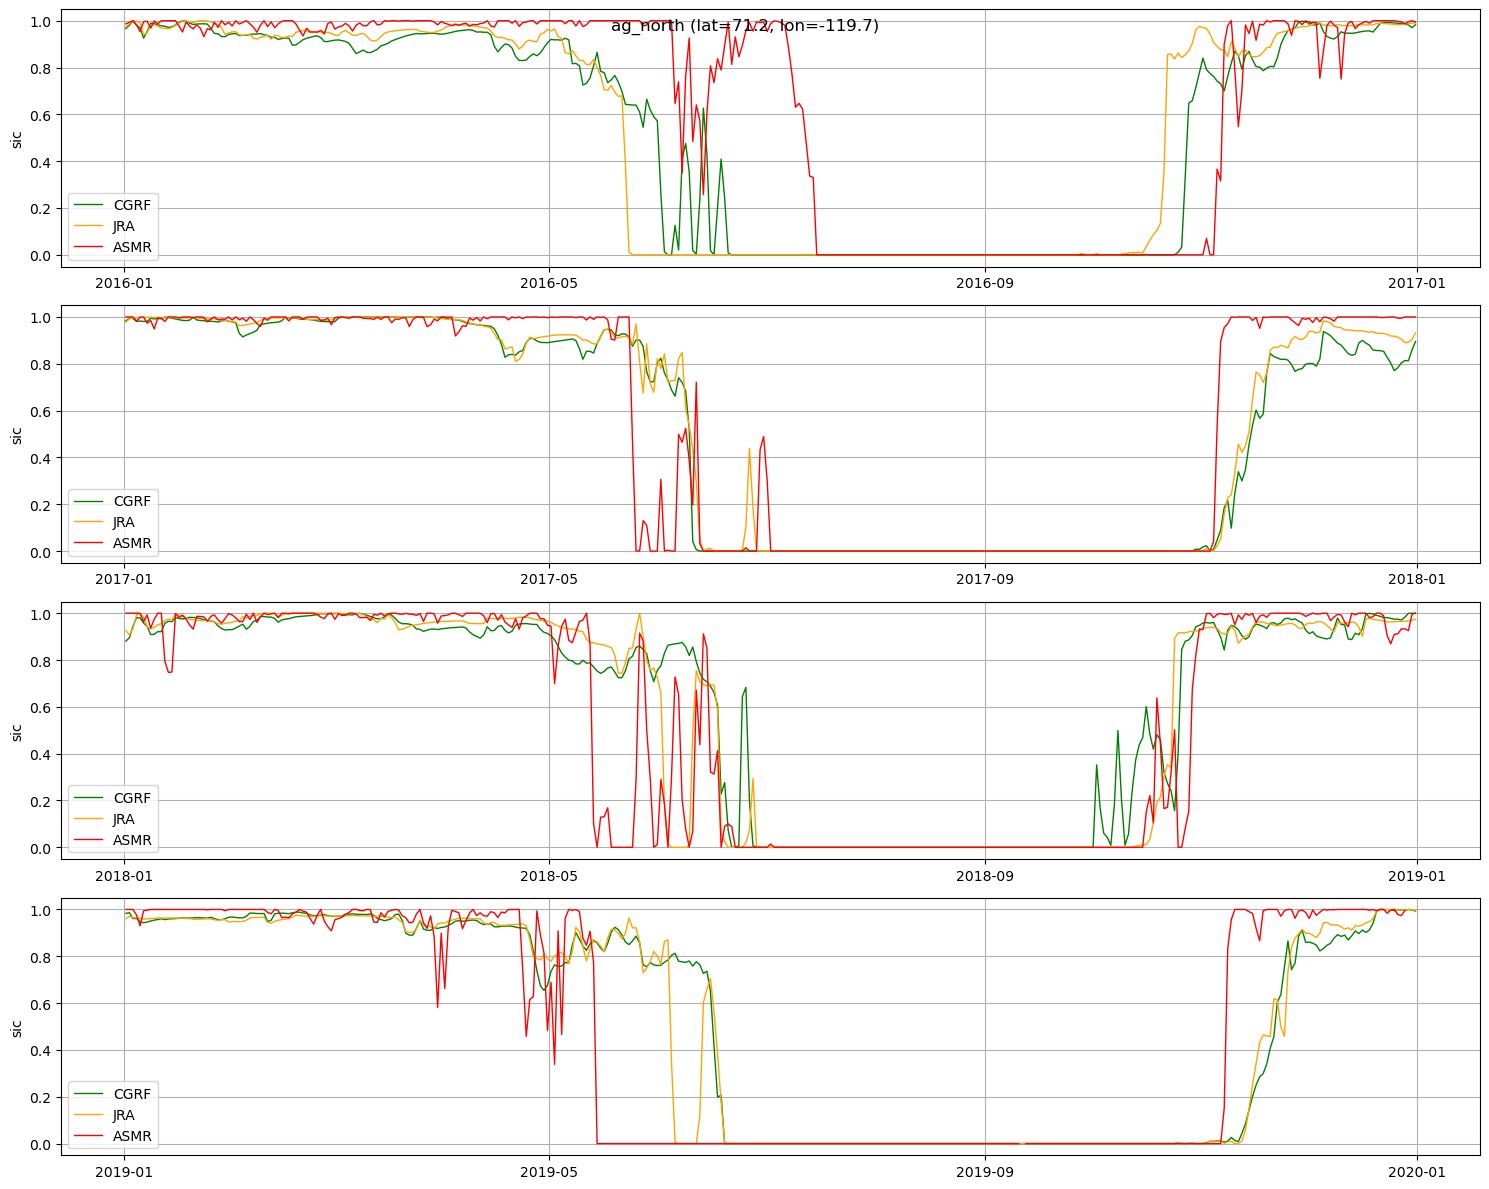

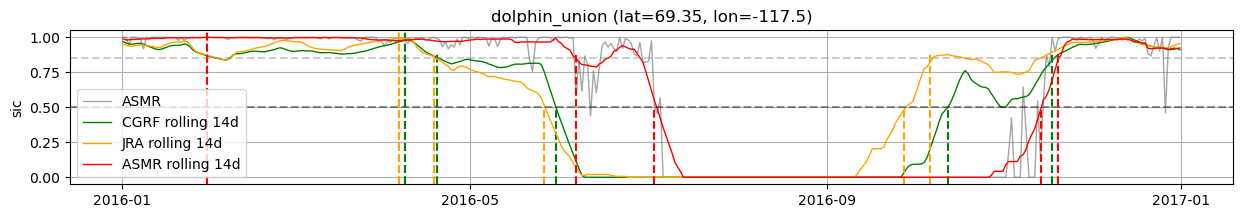

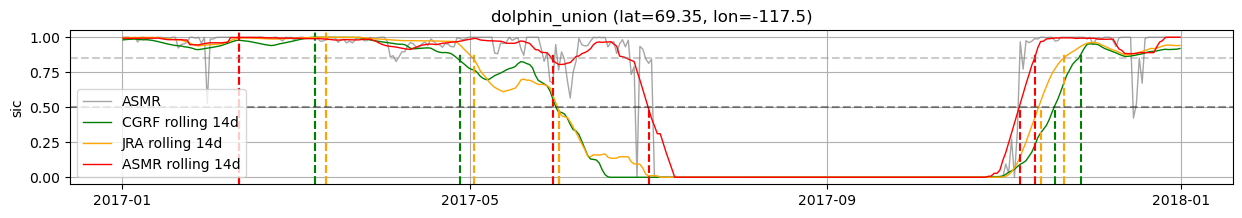

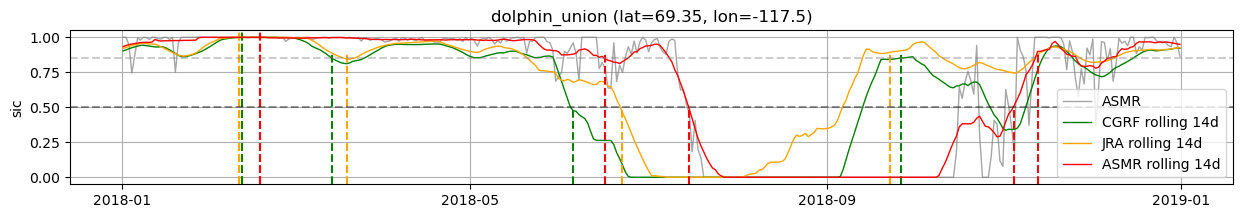

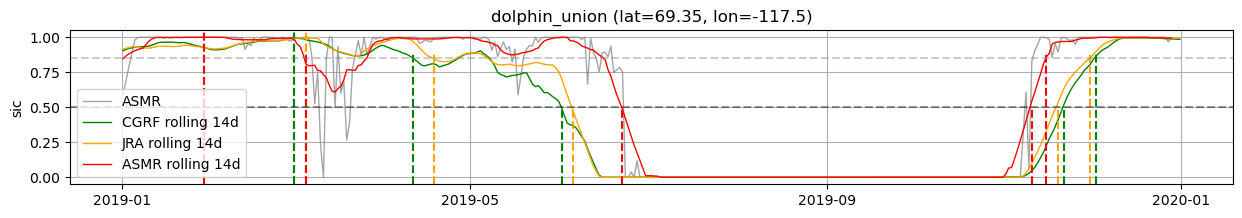

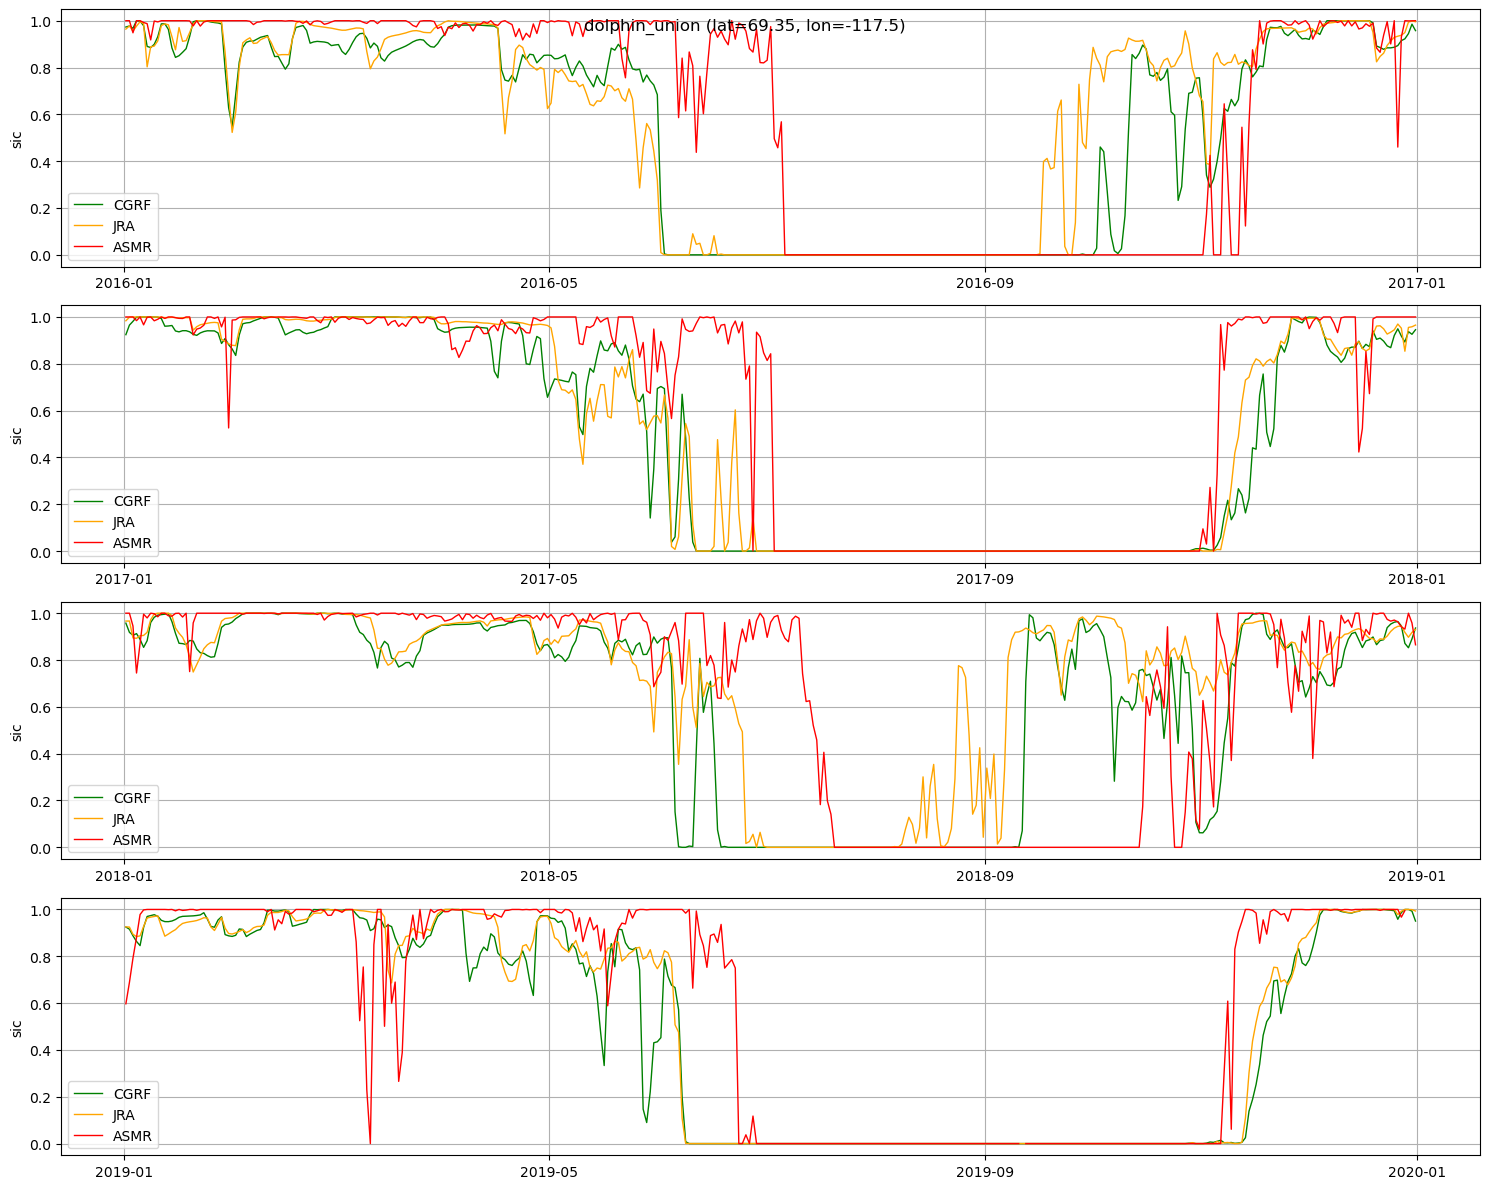

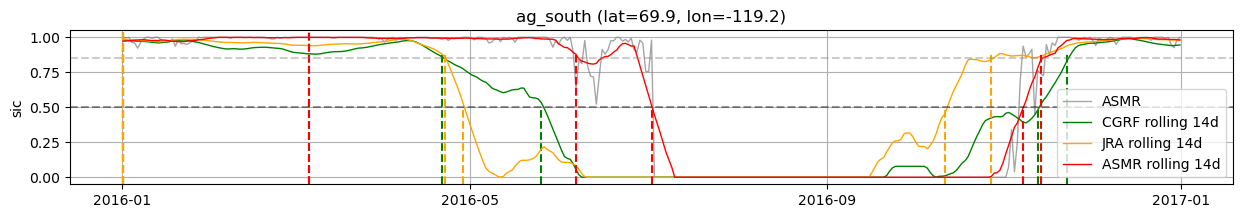

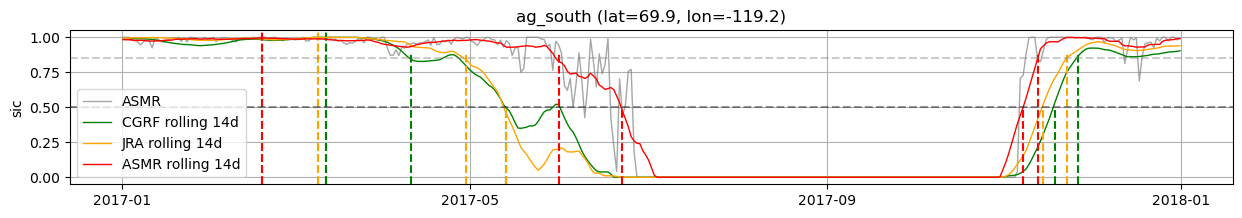

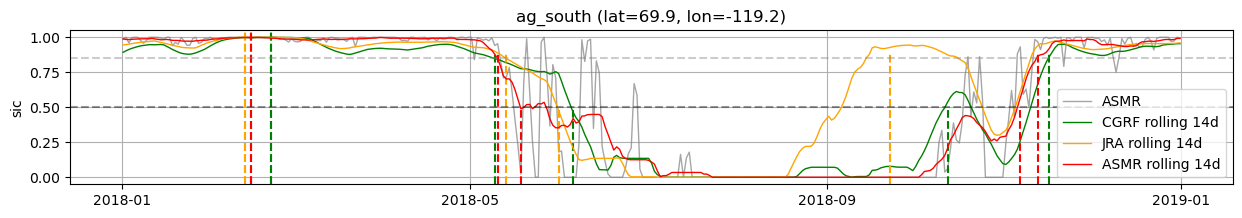

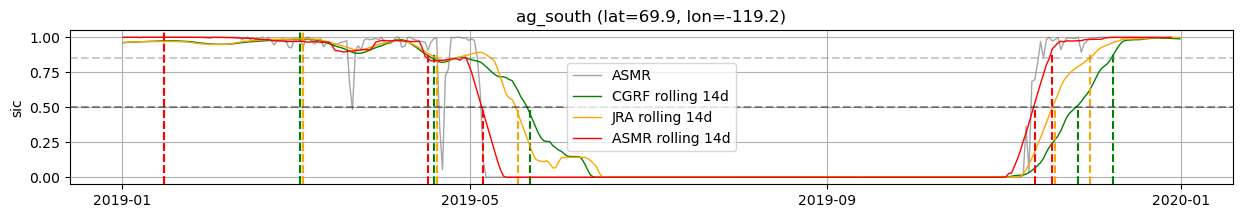

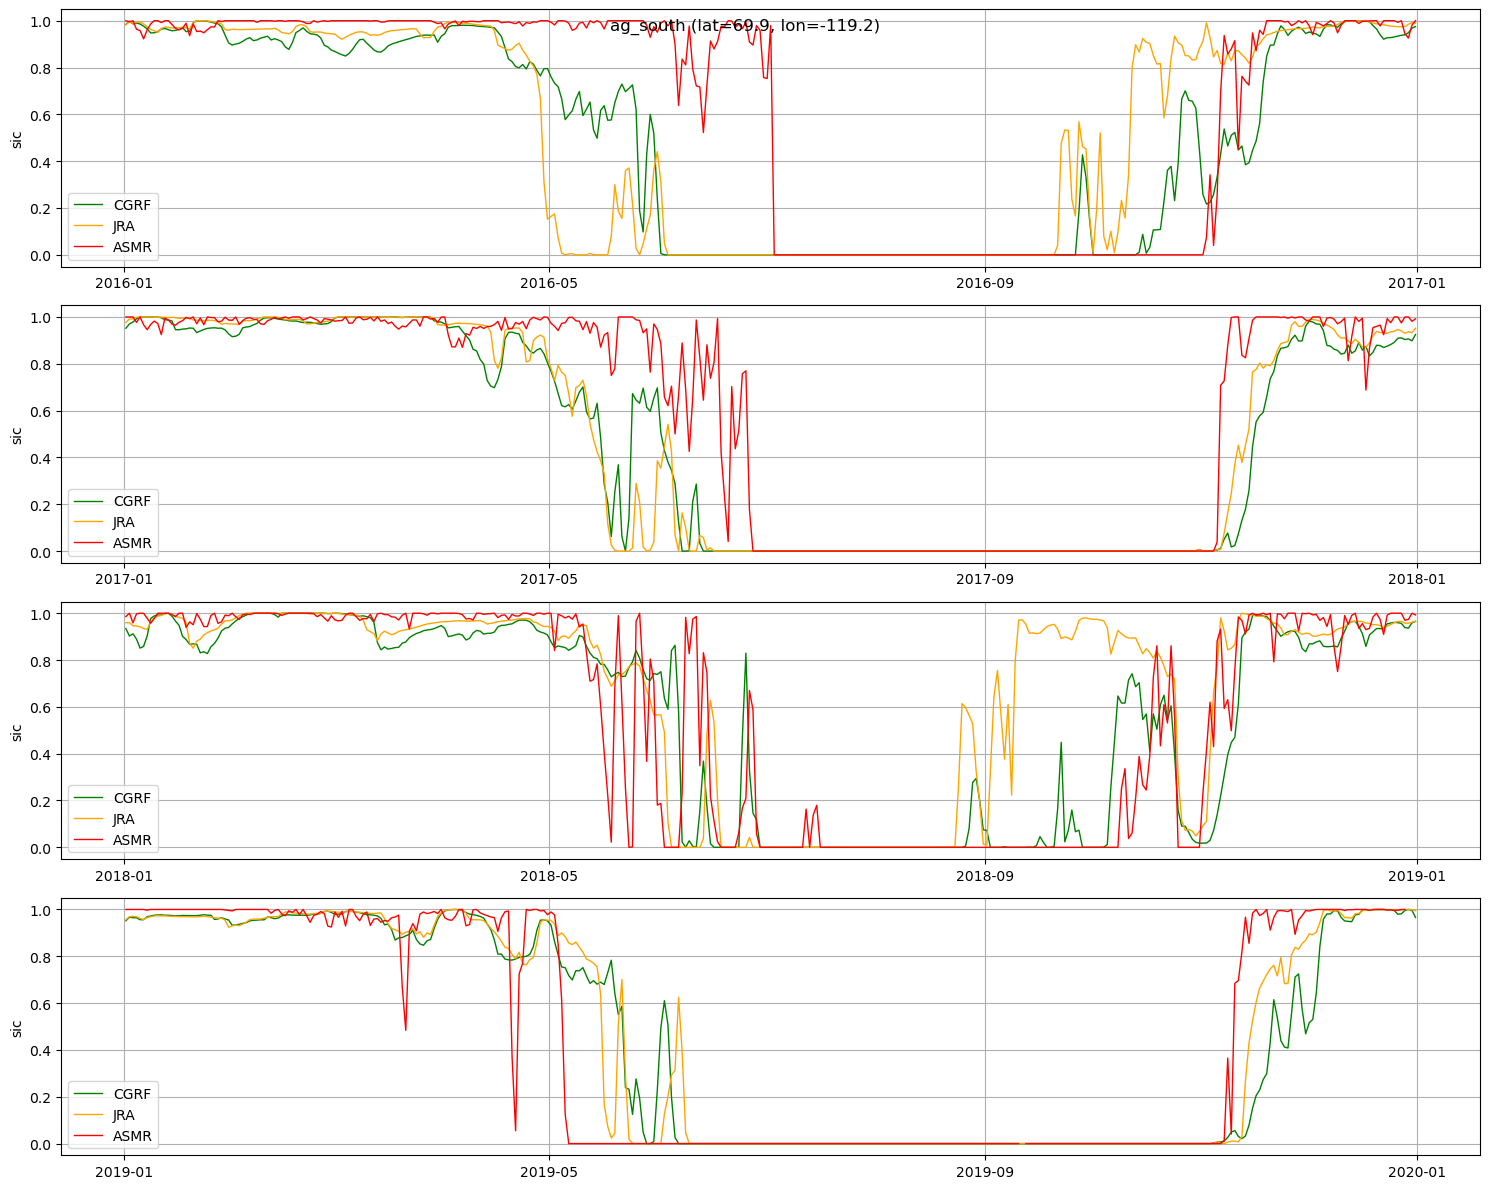

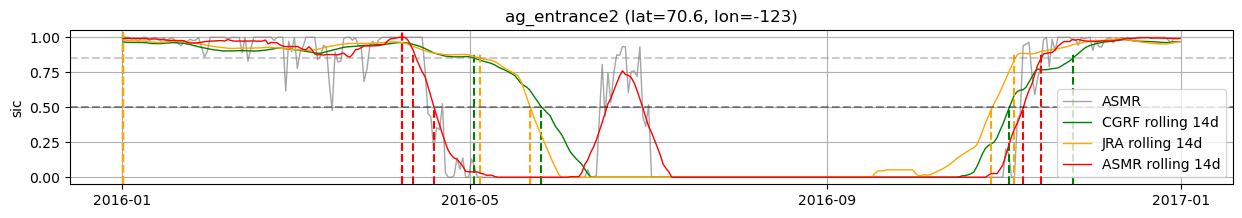

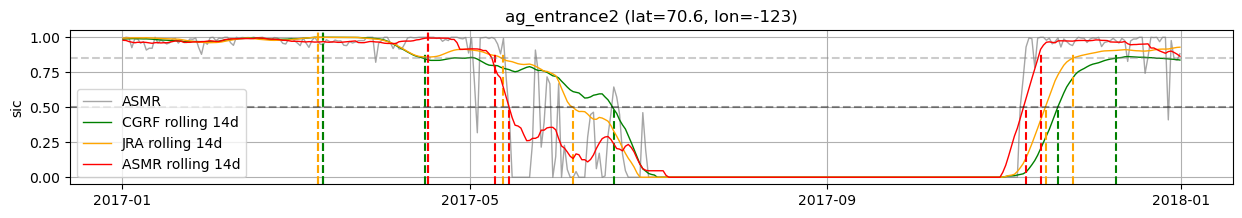

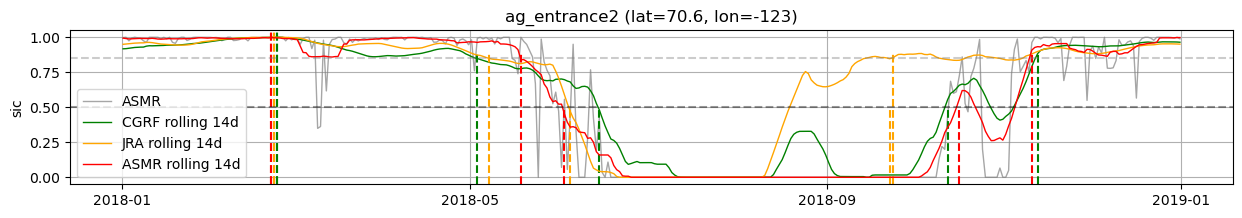

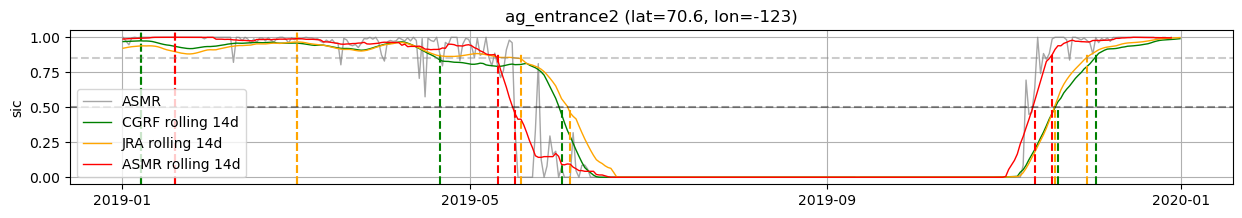

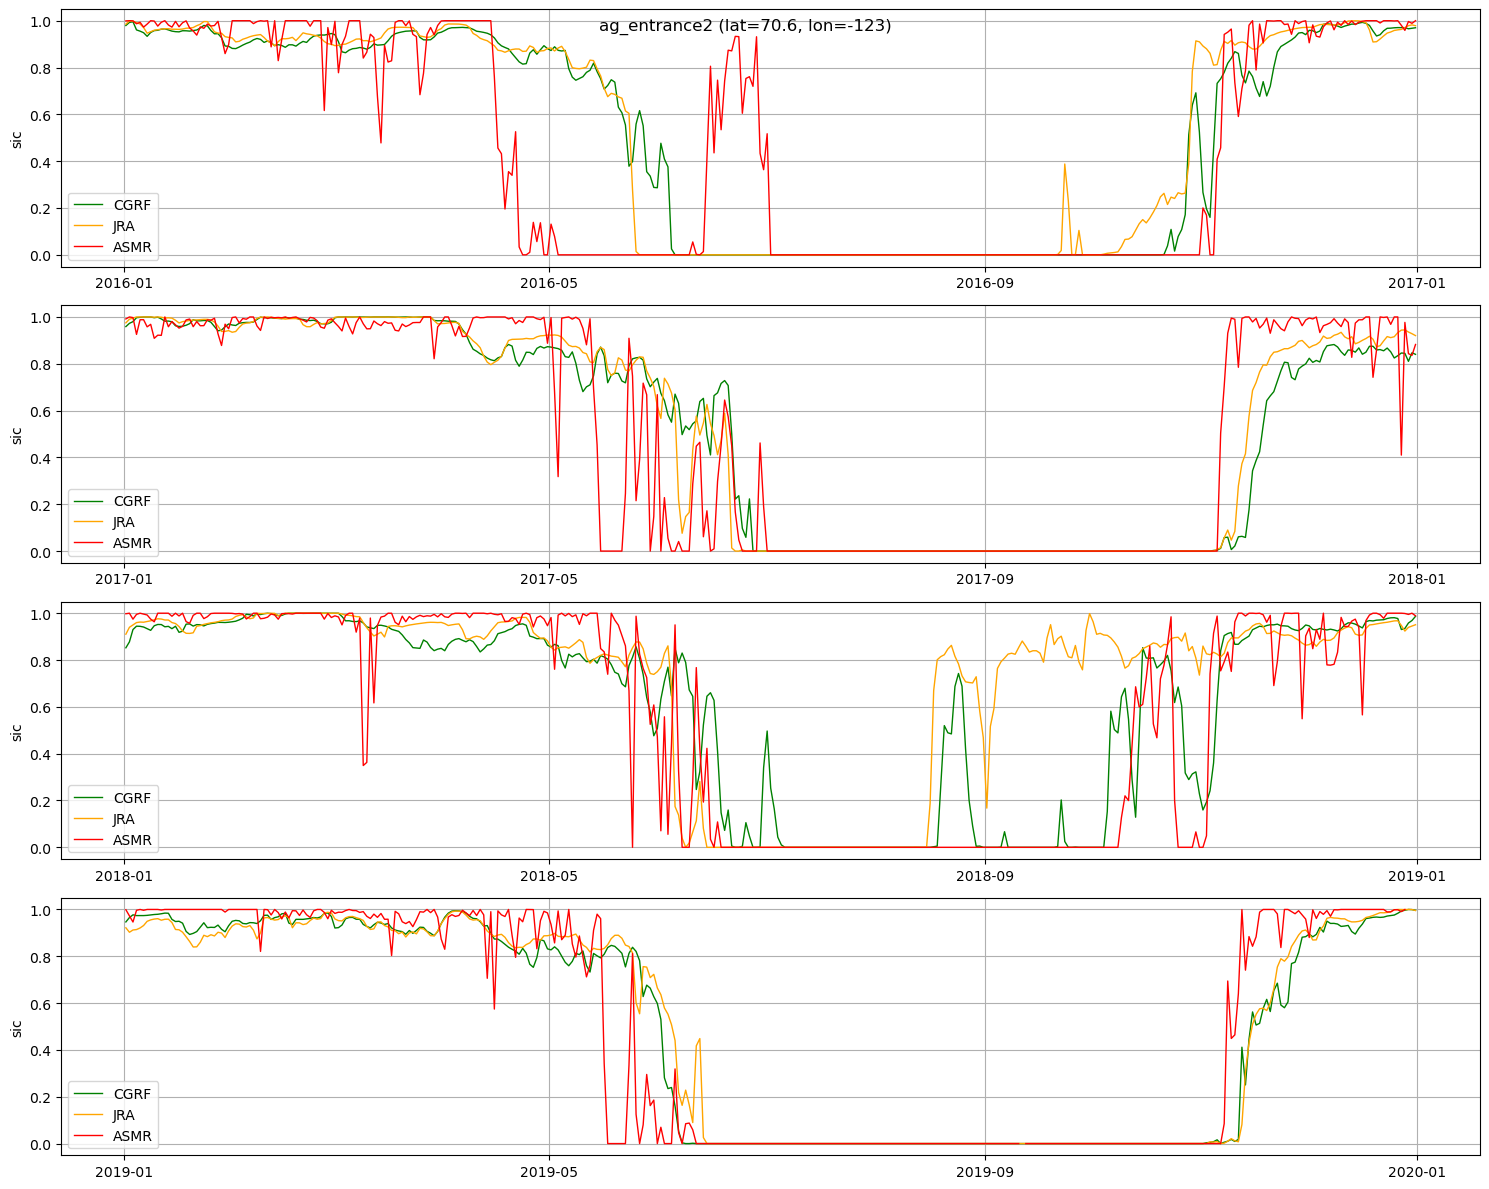

In [18]:
# Locations
locs = {
        'ulu2':{'id':3, 'name':'Ulukhaktok 2','latlon':(70.38,-117.95)},
        'ag_middle':{'id':5, 'name':'Amundsen Gulf middle','latlon':(70.5,-120.3)},
        'ag_north':{'id':6, 'name':'Amundsen Gulf north','latlon':(71.2,-119.7)},
        'dolphin_union':{'id':8, 'name':'Dolphin Union strait','latlon':(69.35,-117.5)},
        'ag_south':{'id':9, 'name':'Amundsen Gulf south','latlon':(69.9,-119.2)},
        # 'ag_entrance1':{'id':10, 'name':'Amundsen Gulf entrance 1','latlon':(71,-126)},
        'ag_entrance2':{'id':11, 'name':'Amundsen Gulf entrance 2','latlon':(70.6,-123)},
       }

years1 = [2003,2005,2007,2009] #,2011,2013,2015]
years2 = list(range(2016,2020))
years = years2

for l in locs:
    lat,lon = locs[l]['latlon']
    figtitle = f"{l} (lat={lat}, lon={lon})"
    print(figtitle)
    
    # SAMPLES
    naa_sample = utils.load_naa_sic('DFS',2003)
    asmr_sample = utils.load_asmr_sic(2003,10)
    xy_naa = utils.find_closest_loc(naa_sample,lat,lon)
    xy_asmr = utils.find_closest_loc(asmr_sample,lat,lon)

    data,d = {},{}
    for year in years:
        print(year)

        # LOAD SIC
        if year not in data:
            data[year] = {}
        for forcing in ['CGRF','JRA']: #['DFS','CGRF','JRA']: # ['CGRF','JRA']: # ['DFS','CGRF','JRA']
            data[year][forcing] = utils.load_naa_sic(forcing,year,xy_naa).sic
        data[year]['ASMR'] = utils.load_asmr_sic(year,'*',xy_asmr).sic #.resample(time="1D").interpolate("linear")

        # REFORMAT TIMES
        cftime_series = data[year]['CGRF'].time
        data[year]['ASMR']['time'] = cftime_series[:len(data[year]['ASMR']['time'])]
        data[year]['JRA']['time'] = cftime_series

        # PROCESS SIC
        d[year] = {k:{t:proc_sic(data[year][k],threshold=t,timedim=timedim) for t in [50,85]} for k in data[year]}
        
        # PLOT DATES
        sp0 = f'/home/pfarnole/data/sibd/plots/sic_dates_{l}_{year}.png'
        plot_dates(year,data,d,figtitle,sp0)
    
    # PLOT SIC DAILY
    sp1 = f'/home/pfarnole/data/sibd/plots/daily_sic_{l}_{min(years)}-{max(years)-1}.png'
    plot_daily_sic(years,data,figtitle,sp1)
    